# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [3]:
# os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"
# import cupy as cp

In [4]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [5]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colorsys

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [8]:
FONTSIZE = 20

In [9]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

# Functions

In [10]:
def generate_pairs(lst):
    """
    Generates all unique pairs from a list.

    Parameters:
    - lst (list): The list to generate pairs from.

    Returns:
    - list: A list of tuples, each containing a unique pair from the input list.
    """
    n = len(lst)
    return [(lst[i], lst[j]) for i in range(n) for j in range(i+1, n)]

In [11]:
def update_array_by_mask(array, mask, value=np.nan):
    """
    """
    result = array.copy()
    result[mask] = value
    return result

## Inputs & Data

Explanation of each input and where it comes from.

In [12]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [13]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [14]:
zscore_threshold = 4
VOLTAGE_SCALING_VALUE = 0.195

In [15]:
BAND_TO_FREQ = {"theta": (4,12), "gamma": (30,51)}

In [16]:
OUTPUT_PREFIX = "rce_pilot_3_long_comp"

In [17]:
LFP_TRACES_DF = pd.read_pickle("./proc/{}_01_lfp_traces_and_frames.pkl".format(OUTPUT_PREFIX))

In [18]:
LFP_TRACES_DF.shape

(20, 24)

## Preprocessing

In [19]:
original_trace_columns = [col for col in LFP_TRACES_DF.columns if "trace" in col]

In [20]:
original_trace_columns

['vHPC_lfp_trace',
 'BLA_lfp_trace',
 'LH_lfp_trace',
 'MD_lfp_trace',
 'mPFC_lfp_trace']

In [21]:
for col in original_trace_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: x.astype(np.float32) * VOLTAGE_SCALING_VALUE)

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [22]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,lfp_timestamps,vHPC_lfp_trace,BLA_lfp_trace,LH_lfp_trace,MD_lfp_trace,mPFC_lfp_trace
0,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[1, 88], [1286, 1486], [3282, 3482], [4480, 4...","[[1, 88], [259, 278], [310, 365], [366, 382], ...",[],20240317_151922_long_comp_subj_3-1_and_3-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-1_t6b6_merged,3.1,...,"[-2, 1384, 1384, 2770, 4156, 5542, 5542, 6928,...","[[0, 87540], [1287955, 1487958], [3287980, 348...","[[0, 87540], [259142, 277740], [309743, 364544...",[],"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[13.65, 36.27, 52.065, 37.635, 10.335, -19.109...","[14.235, 26.13, 34.71, 17.16, -19.695, -50.699...","[9.36, 15.794999, 24.765, 21.255, -3.12, -30.6...","[8.58, 6.24, 9.945, 11.115, -11.115, -33.735, ...","[1.56, 10.724999, 40.754997, 50.894997, 14.624..."
1,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[2, 132], [1922, 2220], [4906, 5203], [6696, ...","[[2, 132], [387, 415], [463, 546], [548, 571],...",[],20240317_151922_long_comp_subj_3-1_and_3-3.2.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-1_t6b6_merged,3.1,...,"[-2, -2, 1384, 1384, 2770, 2770, 4156, 4156, 5...","[[0, 87540], [1287955, 1487958], [3287980, 348...","[[0, 87540], [259142, 277740], [309743, 364544...",[],"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[13.65, 36.27, 52.065, 37.635, 10.335, -19.109...","[14.235, 26.13, 34.71, 17.16, -19.695, -50.699...","[9.36, 15.794999, 24.765, 21.255, -3.12, -30.6...","[8.58, 6.24, 9.945, 11.115, -11.115, -33.735, ...","[1.56, 10.724999, 40.754997, 50.894997, 14.624..."
2,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[1, 88], [1286, 1486], [3282, 3482], [4480, 4...","[[1, 88], [259, 278], [310, 365], [366, 382], ...",[],20240317_151922_long_comp_subj_3-1_and_3-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-3_t5b5_merged,3.3,...,"[-2, 1384, 1384, 2770, 4156, 5542, 5542, 6928,...","[[0, 87540], [1287955, 1487958], [3287980, 348...","[[0, 87540], [259142, 277740], [309743, 364544...",[],"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[-44.655, -60.839996, -79.95, -87.36, -84.045,...","[-36.465, -39.78, -49.335, -56.355, -43.484997...","[-58.109997, -57.914997, -63.179996, -70.97999...","[-36.27, -36.66, -38.805, -42.899998, -33.735,...","[-32.175, -22.23, -23.984999, -41.73, -42.12, ..."
3,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[2, 132], [1922, 2220], [4906, 5203], [6696, ...","[[2, 132], [387, 415], [463, 546], [548, 571],...",[],20240317_151922_long_comp_subj_3-1_and_3-3.2.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-3_t5b5_merged,3.3,...,"[-2, -2, 1384, 1384, 2770, 2770, 4156, 4156, 5...","[[0, 87540], [1287955, 1487958], [3287980, 348...","[[0, 87540], [259142, 277740], [309743, 364544...",[],"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[-44.655, -60.839996, -79.95, -87.36, -84.045,...","[-36.465, -39.78, -49.335, -56.355, -43.484997...","[-58.109997, -57.914997, -63.179996, -70.97999...","[-36.27, -36.66, -38.805, -42.899998, -33.735,...","[-32.175, -22.23, -23.984999, -41.73, -42.12, ..."
4,NaN,20240317_172017_long_comp_subj_4-2_and_4-3,"[[1, 102], [1300, 1501], [3297, 3497], [4494, ...","[[1, 102], [115, 153], [191, 245], [261, 263],...",[],20240317_172017_long_comp_subj_4-2_and_4-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_172017_long_comp_subj_4-2_t6b6_merged,4.2,...,"[-2, 1384, 2770, 2770, 4156, 5542, 5542, 6928,...","[[0, 102220], [1302635, 1502636], [3302656, 35...","[[0, 102220], [114617, 153218], [191021, 24402...",[],"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[10.53, 30.615,

# Calculating modified zscore

`0.6745(xi – x̃) / MAD`

In [23]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_MAD".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: stats.median_abs_deviation(x))

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [24]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_modified_zscore".format(brain_region)
    MAD_column = "{}_lfp_MAD".format(brain_region)

    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: 0.6745 * (x[col] - np.median(x[col])) / x[MAD_column], axis=1)

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [25]:
LFP_TRACES_DF[updated_column]

0     [0.029157063, 0.120515846, 0.4198617, 0.520939...
1     [0.029157063, 0.120515846, 0.4198617, 0.520939...
2     [-0.25584483, -0.17676552, -0.19072068, -0.331...
3     [-0.25584483, -0.17676552, -0.19072068, -0.331...
4     [0.30132985, 0.51685053, 0.70443326, 0.6006641...
5     [0.30132985, 0.51685053, 0.70443326, 0.6006641...
6     [-0.011336134, -0.19460364, -0.3287479, -0.211...
7     [-0.011336134, -0.19460364, -0.3287479, -0.211...
8     [-0.7282213, -0.9152508, -1.0784042, -1.159980...
9     [-0.21009016, -0.93619114, -1.1812963, -0.6321...
10    [0.58418226, 1.160678, 1.3624516, 1.0357707, 1...
11    [0.63150406, 0.74168134, 1.0695258, 1.1259581,...
12    [-0.22914198, -0.54759055, -0.69565153, -0.549...
13    [-0.26757026, -0.19881956, -0.027871901, -0.01...
14    [-0.44513106, -1.0010589, -1.228484, -0.542321...
15    [-0.51904887, -0.4742578, -0.4426406, -0.37677...
16    [0.6042047, 0.80504835, 0.9289019, 0.8853859, ...
17    [-0.4757634, -0.3573244, -0.29710117, -0.3

## calculating root mean sequare

In [26]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.mean(x**2))).astype(np.float32))


vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [27]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,vHPC_lfp_modified_zscore,BLA_lfp_modified_zscore,LH_lfp_modified_zscore,MD_lfp_modified_zscore,mPFC_lfp_modified_zscore,vHPC_lfp_RMS,BLA_lfp_RMS,LH_lfp_RMS,MD_lfp_RMS,mPFC_lfp_RMS
0,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[1, 88], [1286, 1486], [3282, 3482], [4480, 4...","[[1, 88], [259, 278], [310, 365], [366, 382], ...",[],20240317_151922_long_comp_subj_3-1_and_3-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-1_t6b6_merged,3.1,...,"[0.15141837, 0.37952918, 0.5388135, 0.39329448...","[0.16116373, 0.28253394, 0.37007967, 0.1910088...","[0.10752898, 0.17204638, 0.26197967, 0.2267883...","[0.10021142, 0.07708571, 0.11370142, 0.1252642...","[0.029157063, 0.120515846, 0.4198617, 0.520939...","[0.122742355, 0.32614398, 0.46817443, 0.338418...","[0.12974347, 0.23815925, 0.3163608, 0.1564031,...","[0.084228605, 0.14213577, 0.22285485, 0.191269...","[0.0762206, 0.055433165, 0.08834661, 0.0987403...","[0.013956478, 0.09595078, 0.36461297, 0.455330..."
1,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[2, 132], [1922, 2220], [4906, 5203], [6696, ...","[[2, 132], [387, 415], [463, 546], [548, 571],...",[],20240317_151922_long_comp_subj_3-1_and_3-3.2.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-1_t6b6_merged,3.1,...,"[0.15141837, 0.37952918, 0.5388135, 0.39329448...","[0.16116373, 0.28253394, 0.37007967, 0.1910088...","[0.10752898, 0.17204638, 0.26197967, 0.2267883...","[0.10021142, 0.07708571, 0.11370142, 0.1252642...","[0.029157063, 0.120515846, 0.4198617, 0.520939...","[0.122742355, 0.32614398, 0.46817443, 0.338418...","[0.12974347, 0.23815925, 0.3163608, 0.1564031,...","[0.084228605, 0.14213577, 0.22285485, 0.191269...","[0.0762206, 0.055433165, 0.08834661, 0.0987403...","[0.013956478, 0.09595078, 0.36461297, 0.455330..."
2,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[1, 88], [1286, 1486], [3282, 3482], [4480, 4...","[[1, 88], [259, 278], [310, 365], [366, 382], ...",[],20240317_151922_long_comp_subj_3-1_and_3-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-3_t5b5_merged,3.3,...,"[-0.46743464, -0.6375972, -0.8385122, -0.91641...","[-0.28001034, -0.30630964, -0.38211355, -0.437...","[-0.45686954, -0.45532608, -0.49699998, -0.558...","[-0.28231338, -0.2853654, -0.3021516, -0.33419...","[-0.25584483, -0.17676552, -0.19072068, -0.331...","[-0.3722158, -0.5071237, -0.6664126, -0.728177...","[-0.25305068, -0.27605528, -0.3423627, -0.3910...","[-0.40213147, -0.40078202, -0.43721676, -0.491...","[-0.24946693, -0.25214937, -0.26690277, -0.295...","[-0.22272706, -0.15388414, -0.1660329, -0.2888..."
3,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[2, 132], [1922, 2220], [4906, 5203], [6696, ...","[[2, 132], [387, 415], [463, 546], [548, 571],...",[],20240317_151922_long_comp_subj_3-1_and_3-3.2.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-3_t5b5_merged,3.3,...,"[-0.46743464, -0.6375972, -0.8385122, -0.91641...","[-0.28001034, -0.30630964, -0.38211355, -0.437...","[-0.45686954, -0.45532608, -0.49699998, -0.558...","[-0.28231338, -0.2853654, -0.3021516, -0.33419...","[-0.25584483, -0.17676552, -0.19072068, -0.331...","[-0.3722158, -0.5071237, -0.6664126, -0.728177...","[-0.25305068, -0.27605528, -0.3423627, -0.3910...","[-0.40213147, -0.40078202, -0.43721676, -0.491...","[-0.24946693, -0.25214937, -0.26690277, -0.295...","[-0.22272706, -0.15388414, -0.1660329, -0.2888..."
4,NaN,20240317_172017_long_comp_subj_4-2_and_4-3,"[[1, 102], [1300, 1501], [3297, 3497], [4494, ...","[[1, 102], [115, 153], [191, 245], [261, 263],...",[],20240317_172017_long_comp_subj_4-2_and_4-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_172017_long_comp_subj_4-2_t6b6_merged,4.2,...,"[0.12940988, 0.3313677, 

## Filtering for zscore value

In [28]:
zscore_columns = [col for col in LFP_TRACES_DF.columns if "zscore" in col]

In [29]:
zscore_columns

['vHPC_lfp_modified_zscore',
 'BLA_lfp_modified_zscore',
 'LH_lfp_modified_zscore',
 'MD_lfp_modified_zscore',
 'mPFC_lfp_modified_zscore']

In [30]:
for col in zscore_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.abs(x) >= zscore_threshold)

vHPC_lfp_modified_zscore
BLA_lfp_modified_zscore
LH_lfp_modified_zscore
MD_lfp_modified_zscore
mPFC_lfp_modified_zscore


In [31]:
LFP_TRACES_DF[updated_column].head()

0    [False, False, False, False, False, False, Fal...
1    [False, False, False, False, False, False, Fal...
2    [False, False, False, False, False, False, Fal...
3    [False, False, False, False, False, False, Fal...
4    [False, False, False, False, False, False, Fal...
Name: mPFC_lfp_mask, dtype: object

In [32]:
LFP_TRACES_DF[updated_column].iloc[0].shape

(2291031,)

In [33]:
sum(LFP_TRACES_DF[updated_column].iloc[0])

2379

- Filtering raw traces by zscore

In [34]:
LFP_TRACES_DF[col].head()

0    [0.029157063, 0.120515846, 0.4198617, 0.520939...
1    [0.029157063, 0.120515846, 0.4198617, 0.520939...
2    [-0.25584483, -0.17676552, -0.19072068, -0.331...
3    [-0.25584483, -0.17676552, -0.19072068, -0.331...
4    [0.30132985, 0.51685053, 0.70443326, 0.6006641...
Name: mPFC_lfp_modified_zscore, dtype: object

In [35]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_trace_filtered".format(brain_region)    
    mask_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: update_array_by_mask(x[col], x[mask_column]), axis=1)

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [36]:
LFP_TRACES_DF[col].head()

0    [1.56, 10.724999, 40.754997, 50.894997, 14.624...
1    [1.56, 10.724999, 40.754997, 50.894997, 14.624...
2    [-32.175, -22.23, -23.984999, -41.73, -42.12, ...
3    [-32.175, -22.23, -23.984999, -41.73, -42.12, ...
4    [26.91, 47.969997, 66.299995, 56.159996, 59.86...
Name: mPFC_lfp_trace, dtype: object

In [37]:
sum(np.isnan(LFP_TRACES_DF[col].iloc[0]))

0

- Calculating RMS of filtered signal

In [38]:
filtered_trace_column = [col for col in LFP_TRACES_DF if "lfp_trace_filtered" in col]

In [39]:
for col in filtered_trace_column:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS_filtered".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.nanmean(x**2))).astype(np.float32))

vHPC_lfp_trace_filtered
BLA_lfp_trace_filtered
LH_lfp_trace_filtered
MD_lfp_trace_filtered
mPFC_lfp_trace_filtered


# Power Calcuation

- Getting the column name of all the traces

In [40]:
input_columns = [col for col in LFP_TRACES_DF.columns if "RMS" in col and "filtered" in col]

In [41]:
input_columns

['vHPC_lfp_RMS_filtered',
 'BLA_lfp_RMS_filtered',
 'LH_lfp_RMS_filtered',
 'MD_lfp_RMS_filtered',
 'mPFC_lfp_RMS_filtered']

In [42]:
for col in input_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: np.round(x.astype(np.float32), decimals=3))

vHPC_lfp_RMS_filtered
BLA_lfp_RMS_filtered
LH_lfp_RMS_filtered
MD_lfp_RMS_filtered
mPFC_lfp_RMS_filtered


- Calcuating the power at each frequency band

In [43]:
LFP_TRACES_DF[col].iloc[0]

array([0.015, 0.106, 0.404, ..., 0.01 , 0.072, 0.122], dtype=float32)

In [44]:
for col in input_columns:
    # brain_region = col.split("_")[0]
    brain_region = col.replace("_lfp", "")
    print(brain_region)

    # Define column names
    multitaper_col = f"{brain_region}_power_multitaper"
    connectivity_col = f"{brain_region}_power_connectivity"
    frequencies_col = f"{brain_region}_power_frequencies"
    power_col = f"{brain_region}_power_all_frequencies_all_windows"
    
    try:
        # Apply Multitaper function to the lfp_trace column
        LFP_TRACES_DF[multitaper_col] = LFP_TRACES_DF[col].apply(
            lambda x: Multitaper(
                time_series=x, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
                time_window_duration=TIME_WINDOW_DURATION, 
                time_window_step=TIME_WINDOW_STEP
            )
        )

        # Apply Connectivity function to the multitaper column
        LFP_TRACES_DF[connectivity_col] = LFP_TRACES_DF[multitaper_col].apply(
            lambda x: Connectivity.from_multitaper(x)
        )

        # Apply frequencies and power functions to the connectivity column
        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.frequencies
        )
        LFP_TRACES_DF[power_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.power().squeeze()
        )
        
        LFP_TRACES_DF[power_col] = LFP_TRACES_DF[power_col].apply(lambda x: x.astype(np.float32))
            
        # Removing unnecessary columns
        LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")
    
    except Exception as e: 
        print(e)

vHPC_RMS_filtered
BLA_RMS_filtered
LH_RMS_filtered
MD_RMS_filtered
mPFC_RMS_filtered


- Getting the timestamps of the power

In [45]:
LFP_TRACES_DF["power_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])
# .iloc[0][500:-500:500].shape

- Making sure that the timestamps for power makes sense with shape and values

In [46]:
LFP_TRACES_DF["power_timestamps"].head().apply(lambda x: x.shape)

0    (4581,)
1    (4581,)
2    (4581,)
3    (4581,)
4    (5897,)
Name: power_timestamps, dtype: object

In [47]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_all_frequencies_all_windows" in col][0]].iloc[0].shape

(4581, 500)

In [48]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

array([       0,       20,       40, ..., 45820560, 45820580, 45820600])

In [49]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_timestamps" in col][0]].iloc[0]

array([   10000,    20000,    30000, ..., 45790000, 45800000, 45810000])

- Checking if the right frequencies are being used

In [50]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col]].head()

,vHPC_RMS_filtered_power_frequencies,BLA_RMS_filtered_power_frequencies,LH_RMS_filtered_power_frequencies,MD_RMS_filtered_power_frequencies,mPFC_RMS_filtered_power_frequencies
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
4,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [51]:
LFP_TRACES_DF["power_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [52]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col], errors="ignore")

In [53]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,LH_lfp_RMS_filtered,MD_lfp_RMS_filtered,mPFC_lfp_RMS_filtered,vHPC_RMS_filtered_power_all_frequencies_all_windows,BLA_RMS_filtered_power_all_frequencies_all_windows,LH_RMS_filtered_power_all_frequencies_all_windows,MD_RMS_filtered_power_all_frequencies_all_windows,mPFC_RMS_filtered_power_all_frequencies_all_windows,power_timestamps,power_calculation_frequencies
0,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[1, 88], [1286, 1486], [3282, 3482], [4480, 4...","[[1, 88], [259, 278], [310, 365], [366, 382], ...",[],20240317_151922_long_comp_subj_3-1_and_3-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-1_t6b6_merged,3.1,...,"[0.093, 0.158, 0.247, 0.212, -0.031, -0.305, -...","[0.084, 0.061, 0.098, 0.109, -0.109, -0.332, -...","[0.015, 0.106, 0.404, 0.505, 0.145, -0.089, 0....","[[0.0021725139, 0.0018719432, 0.021916905, 0.0...","[[0.0036331136, 0.0036766352, 0.022667041, 0.0...","[[0.0067758905, 0.006356989, 0.02561185, 0.031...","[[0.009621815, 0.010429158, 0.028794985, 0.036...","[[0.007221631, 0.0065711415, 0.028780747, 0.03...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[2, 132], [1922, 2220], [4906, 5203], [6696, ...","[[2, 132], [387, 415], [463, 546], [548, 571],...",[],20240317_151922_long_comp_subj_3-1_and_3-3.2.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-1_t6b6_merged,3.1,...,"[0.093, 0.158, 0.247, 0.212, -0.031, -0.305, -...","[0.084, 0.061, 0.098, 0.109, -0.109, -0.332, -...","[0.015, 0.106, 0.404, 0.505, 0.145, -0.089, 0....","[[0.0021725139, 0.0018719432, 0.021916905, 0.0...","[[0.0036331136, 0.0036766352, 0.022667041, 0.0...","[[0.0067758905, 0.006356989, 0.02561185, 0.031...","[[0.009621815, 0.010429158, 0.028794985, 0.036...","[[0.007221631, 0.0065711415, 0.028780747, 0.03...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[1, 88], [1286, 1486], [3282, 3482], [4480, 4...","[[1, 88], [259, 278], [310, 365], [366, 382], ...",[],20240317_151922_long_comp_subj_3-1_and_3-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-3_t5b5_merged,3.3,...,"[-0.436, -0.435, -0.474, -0.533, -0.474, -0.33...","[-0.27, -0.272, -0.288, -0.319, -0.251, -0.126...","[-0.242, -0.167, -0.18, -0.314, -0.317, -0.278...","[[0.0007998176, 0.0028586437, 0.0029210031, 0....","[[0.0074761137, 0.0103244, 0.01043423, 0.01048...","[[0.007858961, 0.009166312, 0.009503893, 0.010...","[[0.010107513, 0.010485414, 0.01070681, 0.0099...","[[0.012884789, 0.01067535, 0.010974287, 0.0104...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[2, 132], [1922, 2220], [4906, 5203], [6696, ...","[[2, 132], [387, 415], [463, 546], [548, 571],...",[],20240317_151922_long_comp_subj_3-1_and_3-3.2.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-3_t5b5_merged,3.3,...,"[-0.436, -0.435, -0.474, -0.533, -0.474, -0.33...","[-0.27, -0.272, -0.288, -0.319, -0.251, -0.126...","[-0.242, -0.167, -0.18, -0.314, -0.317, -0.278...","[[0.0007998176, 0.0028586437, 0.0029210031, 0....","[[0.0074761137, 0.0103244, 0.01043423, 0.01048...","[[0.007858961, 0.009166312, 0.009503893, 0.010...","[[0.010107513, 0.010485414, 0.01070681, 0.0099...","[[0.012884789, 0.01067535, 0.010974287, 0.0104...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
4,NaN,20240317_172017_long_comp_subj_4-2_and_4-3,"[[1, 102], [1300, 1501], [3297, 3497], [4494, ...","[[1, 102], [115, 153], [191, 245], [261, 263],...",[],

In [54]:
LFP_TRACES_DF["mPFC_RMS_filtered_power_all_frequencies_all_windows"].head()

0    [[0.007221631, 0.0065711415, 0.028780747, 0.03...
1    [[0.007221631, 0.0065711415, 0.028780747, 0.03...
2    [[0.012884789, 0.01067535, 0.010974287, 0.0104...
3    [[0.012884789, 0.01067535, 0.010974287, 0.0104...
4    [[0.005812339, 0.0054055406, 0.018171115, 0.02...
Name: mPFC_RMS_filtered_power_all_frequencies_all_windows, dtype: object

In [55]:
LFP_TRACES_DF["mPFC_RMS_filtered_power_all_frequencies_all_windows"].iloc[4].shape

(5897, 500)

In [56]:
LFP_TRACES_DF["mPFC_lfp_RMS_filtered"].head()

0    [0.015, 0.106, 0.404, 0.505, 0.145, -0.089, 0....
1    [0.015, 0.106, 0.404, 0.505, 0.145, -0.089, 0....
2    [-0.242, -0.167, -0.18, -0.314, -0.317, -0.278...
3    [-0.242, -0.167, -0.18, -0.314, -0.317, -0.278...
4    [0.274, 0.488, 0.675, 0.572, 0.609, 0.695, 0.6...
Name: mPFC_lfp_RMS_filtered, dtype: object

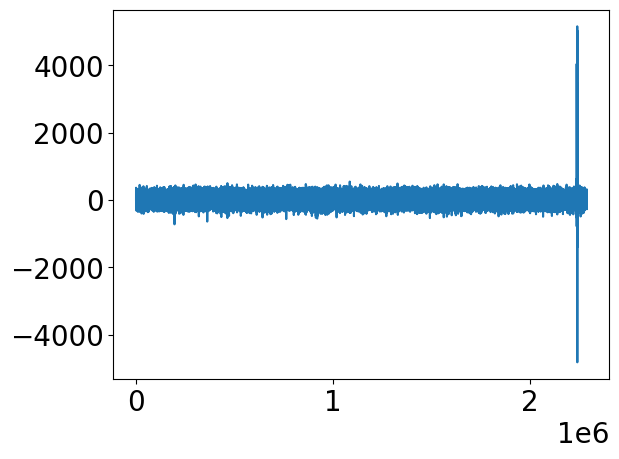

In [57]:
plt.plot(LFP_TRACES_DF["BLA_lfp_trace"].iloc[0])

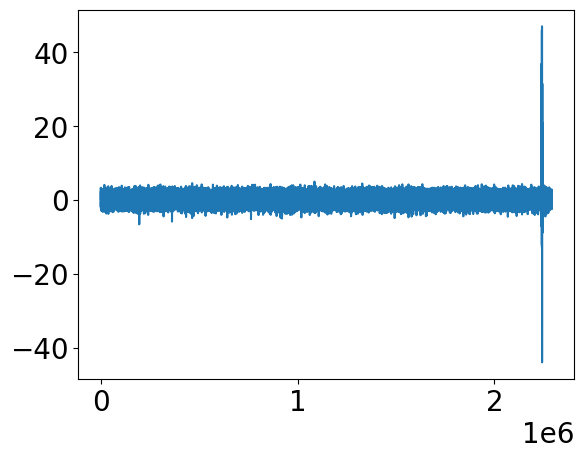

In [58]:
plt.plot(LFP_TRACES_DF["BLA_lfp_RMS"].iloc[0])

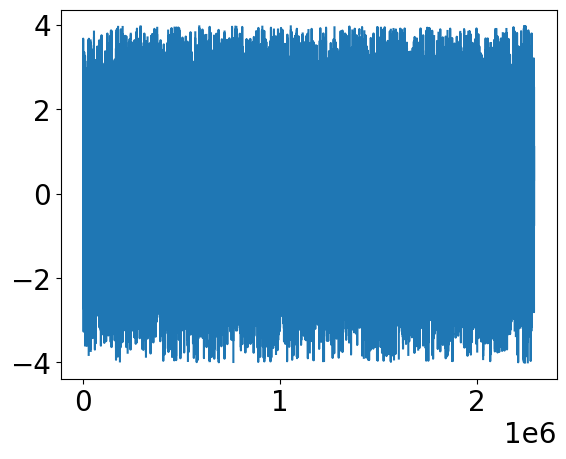

In [59]:
plt.plot(LFP_TRACES_DF["BLA_lfp_RMS_filtered"].iloc[0])

## Calculating phase of signals

In [60]:
from scipy.signal import butter, filtfilt, hilbert

- Filtering for theta and gamma

In [61]:
RMS_columns = [col for col in LFP_TRACES_DF if "RMS" in col and "filtered" not in col]

In [62]:
fs = 1000
order=4

In [63]:
freq_band = [4, 12]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [64]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_theta_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

vHPC_lfp_RMS
BLA_lfp_RMS
LH_lfp_RMS
MD_lfp_RMS
mPFC_lfp_RMS


In [65]:
freq_band = [30, 50]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [66]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_gamma_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

vHPC_lfp_RMS
BLA_lfp_RMS
LH_lfp_RMS
MD_lfp_RMS
mPFC_lfp_RMS


- Calculating the phase

In [67]:
band_columns = [col for col in LFP_TRACES_DF if "band" in col]

In [68]:
band_columns

['vHPC_theta_band',
 'BLA_theta_band',
 'LH_theta_band',
 'MD_theta_band',
 'mPFC_theta_band',
 'vHPC_gamma_band',
 'BLA_gamma_band',
 'LH_gamma_band',
 'MD_gamma_band',
 'mPFC_gamma_band']

In [69]:
for col in band_columns:
    print(col)
    brain_region = col.replace("_band", "")
    updated_column = "{}_phase".format(brain_region)
    print(updated_column)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.angle(hilbert(x), deg=False))

vHPC_theta_band
vHPC_theta_phase
BLA_theta_band
BLA_theta_phase
LH_theta_band
LH_theta_phase
MD_theta_band
MD_theta_phase
mPFC_theta_band
mPFC_theta_phase
vHPC_gamma_band
vHPC_gamma_phase
BLA_gamma_band
BLA_gamma_phase
LH_gamma_band
LH_gamma_phase
MD_gamma_band
MD_gamma_phase
mPFC_gamma_band
mPFC_gamma_phase


In [70]:
LFP_TRACES_DF[col]

0     [-0.015079244, 0.0070941676, 0.033775453, 0.06...
1     [-0.015079244, 0.0070941676, 0.033775453, 0.06...
2     [0.015131413, 0.027095474, 0.03773463, 0.04656...
3     [0.015131413, 0.027095474, 0.03773463, 0.04656...
4     [0.20639607, 0.13862394, 0.061657127, -0.02086...
5     [0.20639607, 0.13862394, 0.061657127, -0.02086...
6     [0.001561778, 0.07595457, 0.14949238, 0.217549...
7     [0.001561778, 0.07595457, 0.14949238, 0.217549...
8     [-0.0081307525, -0.04357865, -0.07822606, -0.1...
9     [0.18496583, 0.13797754, 0.08190751, 0.0191120...
10    [-0.28010583, -0.23104739, -0.1669334, -0.0901...
11    [-0.0497448, -0.027195089, -0.001513123, 0.025...
12    [-0.020004936, -0.042901617, -0.0637859, -0.08...
13    [-0.18341908, -0.20023566, -0.20528391, -0.197...
14    [-0.012846501, 0.01675214, 0.049775597, 0.0836...
15    [0.086564146, 0.12178469, 0.15103419, 0.172188...
16    [0.012113635, 0.03248144, 0.05161425, 0.068234...
17    [-0.020762237, -0.044500872, -0.06506525, 

## Coherence Calculation

- Getting the trace column pairs

In [71]:
brain_region_pairs = generate_pairs(sorted(input_columns))
brain_region_pairs = sorted(brain_region_pairs)


In [72]:
brain_region_pairs

[('BLA_lfp_RMS_filtered', 'LH_lfp_RMS_filtered'),
 ('BLA_lfp_RMS_filtered', 'MD_lfp_RMS_filtered'),
 ('BLA_lfp_RMS_filtered', 'mPFC_lfp_RMS_filtered'),
 ('BLA_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered'),
 ('LH_lfp_RMS_filtered', 'MD_lfp_RMS_filtered'),
 ('LH_lfp_RMS_filtered', 'mPFC_lfp_RMS_filtered'),
 ('LH_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered'),
 ('MD_lfp_RMS_filtered', 'mPFC_lfp_RMS_filtered'),
 ('MD_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered'),
 ('mPFC_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered')]

## Coherece Calculation

- Calculating the coherence

In [73]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    pair_base_name = f"{region_1.split('_')[0]}_{region_2.split('_')[0]}"
    print(pair_base_name)

    try:
        # Define column names
        multitaper_col = f"{pair_base_name}_coherence_multitaper"
        connectivity_col = f"{pair_base_name}_coherence_connectivity"
        frequencies_col = f"{pair_base_name}_coherence_frequencies"
        coherence_col = f"{pair_base_name}_coherence_all_frequencies_all_windows"

        index_to_multitaper = {}
        index_to_connectivity = {}
        index_to_frequencies = {}
        index_to_coherence = {}

        for index, row in LFP_TRACES_DF.iterrows():
            index_to_multitaper[index] = Multitaper(
                time_series=np.array([row[region_1], row[region_2]]).T, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                time_window_step=TIME_WINDOW_STEP, 
                time_window_duration=TIME_WINDOW_DURATION
            )
            print(index)
            index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
            index_to_frequencies[index] = index_to_connectivity[index].frequencies
            index_to_coherence[index] = index_to_connectivity[index].coherence_magnitude()[:,:,0,1]

        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF.index.to_series().map(index_to_frequencies)
        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF.index.to_series().map(index_to_coherence)
        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF[coherence_col].apply(lambda x: x.astype(np.float32))

    except Exception as e: 
        print(e)

    # Drop temporary columns
    LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")

BLA_LH
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
BLA_MD
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
BLA_mPFC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
BLA_vHPC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
LH_MD
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
LH_mPFC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
LH_vHPC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
MD_mPFC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
MD_vHPC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
mPFC_vHPC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [74]:
# for region_1, region_2 in brain_region_pairs:
#     # Define base name for pair
#     pair_base_name = f"{region_1.split('_')[0]}_{region_2.split('_')[0]}"
#     print(pair_base_name)

#     try:
#         # Define column names
#         multitaper_col = f"{pair_base_name}_coherence_multitaper"
#         connectivity_col = f"{pair_base_name}_coherence_connectivity"
#         frequencies_col = f"{pair_base_name}_coherence_frequencies"
#         coherence_col = f"{pair_base_name}_coherence_all_frequencies_all_windows"

#         # Apply Multitaper function
#         LFP_TRACES_DF[multitaper_col] = LFP_TRACES_DF.apply(
#             lambda x: Multitaper(
#                 time_series=np.array([x[region_1], x[region_2]]).T, 
#                 sampling_frequency=RESAMPLE_RATE, 
#                 time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
#                 time_window_step=TIME_WINDOW_STEP, 
#                 time_window_duration=TIME_WINDOW_DURATION
#             ), 
#             axis=1
#         )

#         # Apply Connectivity function
#         LFP_TRACES_DF[connectivity_col] = LFP_TRACES_DF[multitaper_col].apply(
#             lambda x: Connectivity.from_multitaper(x)
#         )

#         # Apply frequencies and coherence functions
#         LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF[connectivity_col].apply(
#             lambda x: x.frequencies
#         )
#         LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF[connectivity_col].apply(
#             lambda x: x.coherence_magnitude()[:,:,0,1]
#         )

#         LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF[coherence_col].apply(lambda x: x.astype(np.float32))

#     except Exception as e: 
#         print(e)

#     # Drop temporary columns
#     LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")

In [75]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,LH_mPFC_coherence_frequencies,LH_mPFC_coherence_all_frequencies_all_windows,LH_vHPC_coherence_frequencies,LH_vHPC_coherence_all_frequencies_all_windows,MD_mPFC_coherence_frequencies,MD_mPFC_coherence_all_frequencies_all_windows,MD_vHPC_coherence_frequencies,MD_vHPC_coherence_all_frequencies_all_windows,mPFC_vHPC_coherence_frequencies,mPFC_vHPC_coherence_all_frequencies_all_windows
0,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[1, 88], [1286, 1486], [3282, 3482], [4480, 4...","[[1, 88], [259, 278], [310, 365], [366, 382], ...",[],20240317_151922_long_comp_subj_3-1_and_3-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-1_t6b6_merged,3.1,...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.9249496, 0.9829557, 0.99013513, 0.9955212,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.060117207, 0.12890075, 0.8475753, 0.995610...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.9391111, 0.95470643, 0.97677666, 0.9876435...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.060699753, 0.048701867, 0.7767016, 0.96149...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.20586579, 0.14527641, 0.8650719, 0.9835180..."
1,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[2, 132], [1922, 2220], [4906, 5203], [6696, ...","[[2, 132], [387, 415], [463, 546], [548, 571],...",[],20240317_151922_long_comp_subj_3-1_and_3-3.2.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-1_t6b6_merged,3.1,...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.9249496, 0.9829557, 0.99013513, 0.9955212,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.060117207, 0.12890075, 0.8475753, 0.995610...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.9391111, 0.95470643, 0.97677666, 0.9876435...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.060699753, 0.048701867, 0.7767016, 0.96149...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.20586579, 0.14527641, 0.8650719, 0.9835180..."
2,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[1, 88], [1286, 1486], [3282, 3482], [4480, 4...","[[1, 88], [259, 278], [310, 365], [366, 382], ...",[],20240317_151922_long_comp_subj_3-1_and_3-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-3_t5b5_merged,3.3,...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.99761665, 0.9637256, 0.9738427, 0.99587125...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.2839897, 0.690091, 0.72793734, 0.97394633,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.9996997, 0.9824718, 0.9791998, 0.97131455,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.25900212, 0.63185, 0.654892, 0.9382397, 0....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.24406572, 0.50392133, 0.59135556, 0.985619..."
3,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[2, 132], [1922, 2220], [4906, 5203], [6696, ...","[[2, 132], [387, 415], [463, 546], [548, 571],...",[],20240317_151922_long_comp_subj_3-1_and_3-3.2.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-3_t5b5_merged,3.3,...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.99761665, 0.9637256, 0.9738427, 0.99587125...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.2839897, 0.690091, 0.72793734, 0.97394633,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.9996997, 0.9824718, 0.9791998, 0.97131455,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.25900212, 0.63185, 0.654892, 0.9382397, 0....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.24406572, 0.50392133, 0.59135556, 0.985619..."
4,NaN,20240317_172017_long_comp_subj_4-2_and_4-3,"[[1, 102], [1300, 1501], [3297, 3497], [4494, ...","[[1, 102], [115, 153], [191, 245],

- Getting the timestamps of the coherence

In [76]:
LFP_TRACES_DF["coherence_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])


- Making sure that the timestamps for coherence makes sense with shape and values

In [77]:
LFP_TRACES_DF["coherence_timestamps"].head().apply(lambda x: x.shape)

0    (4581,)
1    (4581,)
2    (4581,)
3    (4581,)
4    (5897,)
Name: coherence_timestamps, dtype: object

In [78]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_all_frequencies_all_windows" in col][0]].iloc[0].shape

(4581, 500)

In [79]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

array([       0,       20,       40, ..., 45820560, 45820580, 45820600])

In [80]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_timestamps" in col][0]].iloc[0]

array([   10000,    20000,    30000, ..., 45790000, 45800000, 45810000])

- Checking if the right frequencies are being used

In [81]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col]].head()

,BLA_LH_coherence_frequencies,BLA_MD_coherence_frequencies,BLA_mPFC_coherence_frequencies,BLA_vHPC_coherence_frequencies,LH_MD_coherence_frequencies,LH_mPFC_coherence_frequencies,LH_vHPC_coherence_frequencies,MD_mPFC_coherence_frequencies,MD_vHPC_coherence_frequencies,mPFC_vHPC_coherence_frequencies
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
4,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [82]:
LFP_TRACES_DF["coherence_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [83]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col], errors="ignore")

In [84]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,BLA_mPFC_coherence_all_frequencies_all_windows,BLA_vHPC_coherence_all_frequencies_all_windows,LH_MD_coherence_all_frequencies_all_windows,LH_mPFC_coherence_all_frequencies_all_windows,LH_vHPC_coherence_all_frequencies_all_windows,MD_mPFC_coherence_all_frequencies_all_windows,MD_vHPC_coherence_all_frequencies_all_windows,mPFC_vHPC_coherence_all_frequencies_all_windows,coherence_timestamps,coherence_calculation_frequencies
0,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[1, 88], [1286, 1486], [3282, 3482], [4480, 4...","[[1, 88], [259, 278], [310, 365], [366, 382], ...",[],20240317_151922_long_comp_subj_3-1_and_3-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-1_t6b6_merged,3.1,...,"[[0.97476727, 0.9552079, 0.9898461, 0.99497, 0...","[[0.27993318, 0.28660965, 0.92280686, 0.994024...","[[0.9971566, 0.95990616, 0.9832427, 0.9805603,...","[[0.9249496, 0.9829557, 0.99013513, 0.9955212,...","[[0.060117207, 0.12890075, 0.8475753, 0.995610...","[[0.9391111, 0.95470643, 0.97677666, 0.9876435...","[[0.060699753, 0.048701867, 0.7767016, 0.96149...","[[0.20586579, 0.14527641, 0.8650719, 0.9835180...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[2, 132], [1922, 2220], [4906, 5203], [6696, ...","[[2, 132], [387, 415], [463, 546], [548, 571],...",[],20240317_151922_long_comp_subj_3-1_and_3-3.2.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-1_t6b6_merged,3.1,...,"[[0.97476727, 0.9552079, 0.9898461, 0.99497, 0...","[[0.27993318, 0.28660965, 0.92280686, 0.994024...","[[0.9971566, 0.95990616, 0.9832427, 0.9805603,...","[[0.9249496, 0.9829557, 0.99013513, 0.9955212,...","[[0.060117207, 0.12890075, 0.8475753, 0.995610...","[[0.9391111, 0.95470643, 0.97677666, 0.9876435...","[[0.060699753, 0.048701867, 0.7767016, 0.96149...","[[0.20586579, 0.14527641, 0.8650719, 0.9835180...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[1, 88], [1286, 1486], [3282, 3482], [4480, 4...","[[1, 88], [259, 278], [310, 365], [366, 382], ...",[],20240317_151922_long_comp_subj_3-1_and_3-3.1.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-3_t5b5_merged,3.3,...,"[[0.9795295, 0.92010224, 0.9208842, 0.95480806...","[[0.37587917, 0.77335584, 0.7578621, 0.9200043...","[[0.9988069, 0.9959728, 0.9912375, 0.9786582, ...","[[0.99761665, 0.9637256, 0.9738427, 0.99587125...","[[0.2839897, 0.690091, 0.72793734, 0.97394633,...","[[0.9996997, 0.9824718, 0.9791998, 0.97131455,...","[[0.25900212, 0.63185, 0.654892, 0.9382397, 0....","[[0.24406572, 0.50392133, 0.59135556, 0.985619...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,NaN,20240317_151922_long_comp_subj_3-1_and_3-3,"[[2, 132], [1922, 2220], [4906, 5203], [6696, ...","[[2, 132], [387, 415], [463, 546], [548, 571],...",[],20240317_151922_long_comp_subj_3-1_and_3-3.2.v...,NaN,/scratch/back_up/reward_competition_extention/...,20240317_151922_long_comp_subj_3-3_t5b5_merged,3.3,...,"[[0.9795295, 0.92010224, 0.9208842, 0.95480806...","[[0.37587917, 0.77335584, 0.7578621, 0.9200043...","[[0.9988069, 0.9959728, 0.9912375, 0.9786582, ...","[[0.99761665, 0.9637256, 0.9738427, 0.99587125...","[[0.2839897, 0.690091, 0.72793734, 0.97394633,...","[[0.9996997, 0.9824718, 0.9791998, 0.97131455,...","[[0.25900212, 0.63185, 0.654892, 0.9382397, 0....","[[0.24406572, 0.50392133, 0.59135556, 0.985619...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
4,NaN,20240317_172017_long_comp_subj_4-2_and_4-3,"[[1, 102], [1300, 1501], [3297, 3497], [4494,

In [85]:
# LFP_TRACES_DF.to_pickle("./proc/rce2_spectral_granger.pkl")
LFP_TRACES_DF.to_pickle("./proc/{}_02_full_spectral.pkl".format(OUTPUT_PREFIX))
# LFP_TRACES_DF.to_pickle("/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/rce_pilot_2_02_spectral_granger.pkl")

# Calculate Granger's

In [86]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    region_1_base_name = region_1.split('_')[0]
    region_2_base_name = region_2.split('_')[0]

    pair_base_name = f"{region_1_base_name}_{region_2_base_name}"
    print(pair_base_name)

    try:
        # Define column names
        multitaper_col = f"{pair_base_name}_granger_multitaper"
        connectivity_col = f"{pair_base_name}_granger_connectivity"
        frequencies_col = f"{pair_base_name}_granger_frequencies"
        granger_1_2_col = f"{region_1_base_name}_{region_2_base_name}_granger_all_frequencies_all_windows"
        granger_2_1_col = f"{region_2_base_name}_{region_1_base_name}_granger_all_frequencies_all_windows"

        # Apply Multitaper function
        LFP_TRACES_DF[multitaper_col] = LFP_TRACES_DF.apply(
            lambda x: Multitaper(
                time_series=np.array([x[region_1], x[region_2]]).T, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                time_window_step=TIME_WINDOW_STEP, 
                time_window_duration=TIME_WINDOW_DURATION
            ), 
            axis=1
        )
    
        # Apply Connectivity function
        LFP_TRACES_DF[connectivity_col] = LFP_TRACES_DF[multitaper_col].apply(
            lambda x: Connectivity.from_multitaper(x)
        )

        # Apply frequencies and granger functions
        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.frequencies
        )
        
        LFP_TRACES_DF[granger_1_2_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.pairwise_spectral_granger_prediction()[:,:,0,1]
        )

        LFP_TRACES_DF[granger_2_1_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.pairwise_spectral_granger_prediction()[:,:,1,0]
        )

        LFP_TRACES_DF[granger_1_2_col] = LFP_TRACES_DF[granger_1_2_col].apply(lambda x: x.astype(np.float32))
        LFP_TRACES_DF[granger_2_1_col] = LFP_TRACES_DF[granger_2_1_col].apply(lambda x: x.astype(np.float32))
        
    except Exception as e: 
        print(e)

    # Drop temporary columns
    LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")

BLA_LH


Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 4131 of 4581 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.


KeyboardInterrupt: 

- Getting the timestamps of the granger

In [ ]:
LFP_TRACES_DF["granger_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])


- Making sure that the timestamps for granger makes sense with shape and values

In [ ]:
LFP_TRACES_DF["granger_timestamps"].head().apply(lambda x: x.shape)

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_all_frequencies_all_windows" in col][0]].iloc[0].shape

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_timestamps" in col][0]].iloc[0]

- Checking if the right frequencies are being used

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col]].head()

In [ ]:
LFP_TRACES_DF["granger_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [ ]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col], errors="ignore")

In [ ]:
LFP_TRACES_DF.head()

In [ ]:
LFP_TRACES_DF.columns

In [ ]:
# LFP_TRACES_DF.to_pickle("./proc/rce2_spectral_granger.pkl")
LFP_TRACES_DF.to_pickle("./proc/{}_02_full_spectral.pkl".format(OUTPUT_PREFIX))
# LFP_TRACES_DF.to_pickle("/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/rce_pilot_2_02_spectral_granger.pkl")

In [ ]:
raise ValueError()